Compute doubly coprime factorizations of $G_{22}$ and the corresponding closed-loop transfer function $T_{zw}$ in terms of the Youla parameter $Q$

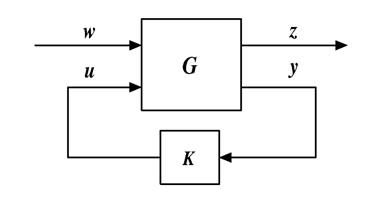

In [45]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import rpc_diism.robust as rb

System definition

In [46]:
# System A matrix
A = np.array([[-0.5, 4, 0],
              [-5, -1, 2],
              [0.2, -2, -1]])
# This defines G11
B1 = np.array([[1],
               [0],
               [0]])
C1 = np.array([1, 0, 0])
D11 = np.array([0])

G11 = ct.StateSpace(A, B1, C1, D11)

# This defines G12
B2 = np.array([[1,0],
              [0,1],
              [0,0]])
D12 = np.array([1,0])
G12 = ct.StateSpace(A, B2, C1, D12)

# This defines G21
C2 = np.array([[1,0,0],
              [0,0,1]])
D21 = np.array([[1],
                [-1]])
G21 = ct.StateSpace(A, B1, C2, D21)

# This defines G22 
D22 = np.array([[0.5,0],
              [0,0.5]])
G22 = ct.StateSpace(A, B2, C2, D22)

# Number of states
n = np.size(A,1)
# Number of controlled inputs and measured outputs
nu = np.size(D22.transpose()@D22,1)

I = np.eye(nu)
Zero = np.zeros([nu,nu])

Computation of coprime factorizations of $G_{22}$

In [47]:
# Compute a state-feedback controller for G22
poles = [-1, -2, -3] # These can be anything (must be stable!)
F = -ct.place(A, B2, poles)

# Compute Mhat, Nhat (right factorization)
AF = A + B2 @ F
CF = C2 + D22 @ F
Mhat = ct.StateSpace(AF, B2, F, I)
Nhat = ct.StateSpace(AF, B2, CF, D22)

# Compute a stable observer for G22
poles = [-4, -5, -6] # These can be anything (must be stable!)
H = -(ct.place(A.transpose(), C2.transpose(), poles)).transpose()

# Compute Mtilde, Ntilde (left factorization)
AH = A + H @ C2
BH = B2 + H @ D22
Mtilde = ct.StateSpace(AH, H, C2, I)
Ntilde = ct.StateSpace(AH, BH, C2, D22)

# Compute the X and Y factors of doubly coprime factorizations
Xhat = ct.StateSpace(AF, -H, CF, I)
Yhat = ct.StateSpace(AF, -H, F, Zero)
Xtilde = ct.StateSpace(AH, -BH, F, I)
Ytilde = ct.StateSpace(AH, -H, F, Zero)

# Factorized G22
G22right = Nhat * rb.invss(Mhat)
G22left = rb.invss(Mtilde) * Ntilde

Verify that factorizations are correct (they both must evaluate to G22)

In [48]:
display(ct.minreal(G22 - G22right, verbose=False))
display(ct.minreal(G22 - G22left, verbose=False))

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[0., 0.],
       [0., 0.]]),
states=0, outputs=2, inputs=2)

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[0., 0.],
       [0., 0.]]),
states=0, outputs=2, inputs=2)

Verify coprimeness

This must be I

In [49]:
display(ct.minreal(Xtilde * Mhat - Ytilde * Nhat, 0.01, verbose=False))

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[1., 0.],
       [0., 1.]]),
states=0, outputs=2, inputs=2)

This must be 0

In [50]:
display(ct.minreal(Xtilde * Yhat - Ytilde * Xhat, 0.01, verbose=False))

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[0., 0.],
       [0., 0.]]),
states=0, outputs=2, inputs=2)

This must be 0

In [51]:
display(ct.minreal(-Ntilde * Mhat + Mtilde * Nhat, 0.01, verbose=False))

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[0., 0.],
       [0., 0.]]),
states=0, outputs=2, inputs=2)

This must be I

In [52]:
display(ct.minreal(-Ntilde * Yhat + Mtilde * Xhat, 0.01, verbose=False))

StateSpace(
array([], shape=(0, 0), dtype=float64),
array([], shape=(0, 2), dtype=float64),
array([], shape=(2, 0), dtype=float64),
array([[1., 0.],
       [0., 1.]]),
states=0, outputs=2, inputs=2)

Compute $T_1$, $T_2$, $T_3$ for the specific control problem

In [53]:
T1 = ct.minreal(G11 + G12 * Yhat * Mtilde * G21, verbose=False)
T2 = ct.minreal(G12 * Mhat, verbose=False)
T3 = ct.minreal(Mtilde * G21, verbose=False)

Take a random stable $Q$ and get a stabilizing controller for free!


In [54]:
AQ = np.array([[-2, 0.5, 0.5],
              [0.1, -1, 2],
              [0, 0, -0.5]])
BQ = np.array([[1,0],
               [0,1],
               [0,0]])
CQ = np.array([[1, 0, 0],
              [0,0,1]])
DQ = np.array([[0,0],
              [0,0]])
Q = ct.StateSpace(AQ, BQ, CQ, DQ)

Compute $T_{zw}$ from $Q$

In [55]:
Tzw = ct.minreal(T1 - T2 * Q * T3, verbose=False)

Check the eigenvalues of $T_{zw}$

In [56]:
display(np.linalg.eigvals(Tzw.A))

array([-0.82516463+4.89048738e+00j, -0.82516463-4.89048738e+00j,
       -0.82516463+4.89048738e+00j, -0.82516463-4.89048738e+00j,
       -0.82516463+4.89048738e+00j, -0.82516463-4.89048738e+00j,
       -6.        +0.00000000e+00j, -6.        +0.00000000e+00j,
       -5.        +0.00000000e+00j, -5.        +0.00000000e+00j,
       -4.        +0.00000000e+00j, -4.        +0.00000000e+00j,
       -0.5       +0.00000000e+00j, -0.84967074+0.00000000e+00j,
       -0.84967074+5.02235954e-15j, -0.84967074-5.02235954e-15j,
       -1.        +0.00000000e+00j, -1.        +0.00000000e+00j,
       -0.95227744+0.00000000e+00j, -3.        +0.00000000e+00j,
       -3.        +0.00000000e+00j, -2.        +0.00000000e+00j,
       -2.        +0.00000000e+00j, -2.04772256+0.00000000e+00j])

Compute the controller from $Q$

In [57]:
K = ct.minreal((Yhat - Mhat * Q) * rb.invss(Xhat - Nhat * Q), verbose=False)

Compute $T_{zw}$ from the controller

In [58]:
Id = ct.tf(ct.ss([],[],[],np.eye(2))) # Identity
Tzw2 = ct.minreal(G11 + G12 * K * rb.invss(ct.ss(Id - G22 * K)) * G21, verbose=False)

Singular values of Tzw and Tzw2, superimposed

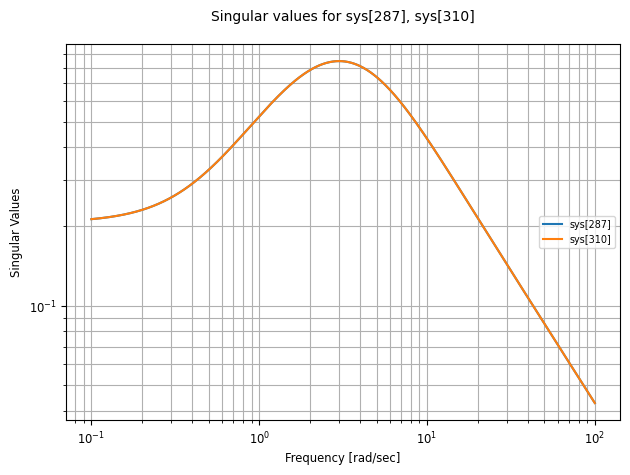

In [59]:
ct.freqplot.singular_values_plot(Tzw)
ct.freqplot.singular_values_plot(Tzw2)

Singular values of Tzw-Tzw2 (ideally zero, but there may be a slight numerical error)

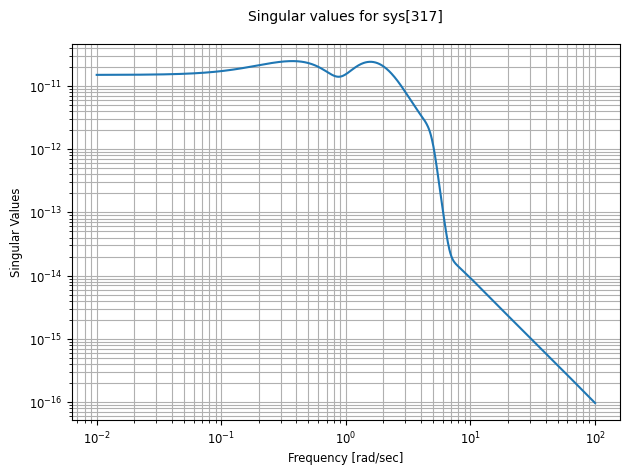

In [60]:
dT = ct.minreal(Tzw - Tzw2, verbose=False)
ct.freqplot.singular_values_plot(dT)